In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # progress bar
from glob import glob # reading multiple files at once
import cv2 # opencv
import matplotlib.pyplot as plt
import seaborn as sns
import numba
import skimage
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


# Contents

### [1. Introduction](#Introduction)
* [Spot-Vegetation](#Spot-V)  
* [Proba-V](#Proba-V)  
* [Super Resolution](#Super Resolution)

### [2. Problem Statement](#Problem)  

### [3. Data](#Data)  
* [Exploratory Data Analysis](#EDA)  

### [4. Analysis](#Analysis)  
### [5. Implementation](#Implementation)  

### [6. FSRCNN Implementation](#FSRCNN)
### [7. Results](#Results)
### [8. Conclusion](#Conclusion)

<a id="Introduction" ></a>

<a id="Introduction"></a>
# Introduction



<a id="Spot-V"></a>
### 1.1 SPOT-VEGETATION
The overall objectives of the "VEGETATION" systems is to provide accurate measurements of basic characteristics of vegetation canopies on an operational basis,
* Either for scientific studies involving both regional and global scales experiments over long time periods (for example development of models of the biosphere dynamics interacting with climate models), 
* Or for systems designed to monitor important vegetation resources, like crops, pastures and forests.

<a id="Proba-V"></a>
### 1.2 PROBA-V
**PROBA-V** (Project for On-Board Autonomy – Vegetation) is an ESA (European Space
Agency) mission developed within the framework of the Agency’s General Support
Technology Programme (GSTP) devoted to the **observation of the Earth’s vegetation**.The Proba-V mission provides multispectral images to study the evolution of the vegetation cover on a daily and global basis. The 'V' stands for Vegetation. It is a miniaturised satellite tasked with a full-scale mission: to map land cover and vegetation growth across the entire planet every two days. It was initiated by the Space and Aeronautics department of the BELgian Science Policy Office launched into space from ELA-1( *Ensemble de Lancement Ariane* 1 ) at Guiana Space Centre on board Vega flight VV02, on 7 May 2013. It is built by QinetiQ Space N.V. and operated by European Space Agency and uses a PROBA platform. It was launched to support **applications such as land use, worldwide vegetation classification, crop monitoring, famine prediction, food security, disaster monitoring and biosphere studies**.



The main PROBA-V payload is the Vegetation sensor: a multispectral pushbroom spectrometer with 4 spectral bands and with a very large swath of 2285 km to guarantee daily coverage above 35° latitude.

The payload consists of 3 identical cameras, each with a very compact Three Mirror Anastigmat (TMA) telescope. Each TMA, having a FOV of 34°, contains **4 spectral bands: 3 bands in the visible range (Blue, Red and NIR) and one band in the SWIR spectral range**. The swath Total FOV is 103°.



<a id="Super Resolution"></a>
### 1.3 Super Resolution

Super resolution is the process of upscaling and or improving the details within an image. Often a low resolution image is taken as an input and the same image is upscaled to a higher resolution, which is the output. The details in the high resolution output are filled in where the details are essentially unknown.

Super resolution has wide scope in so many different fields including satellite imagery, microscopes, and telescopes. There is so much of old low-resolution data available that be used by performing super resolution and finding new insights from the data, which will save cost. Therefore, this task of super-resolution can have great impact on a lot of industries and hence this needs to be studied and more researched upon. 

The below image is taken from kelvins proba-v challenge [website.](https://kelvins.esa.int/proba-v-super-resolution/home/)

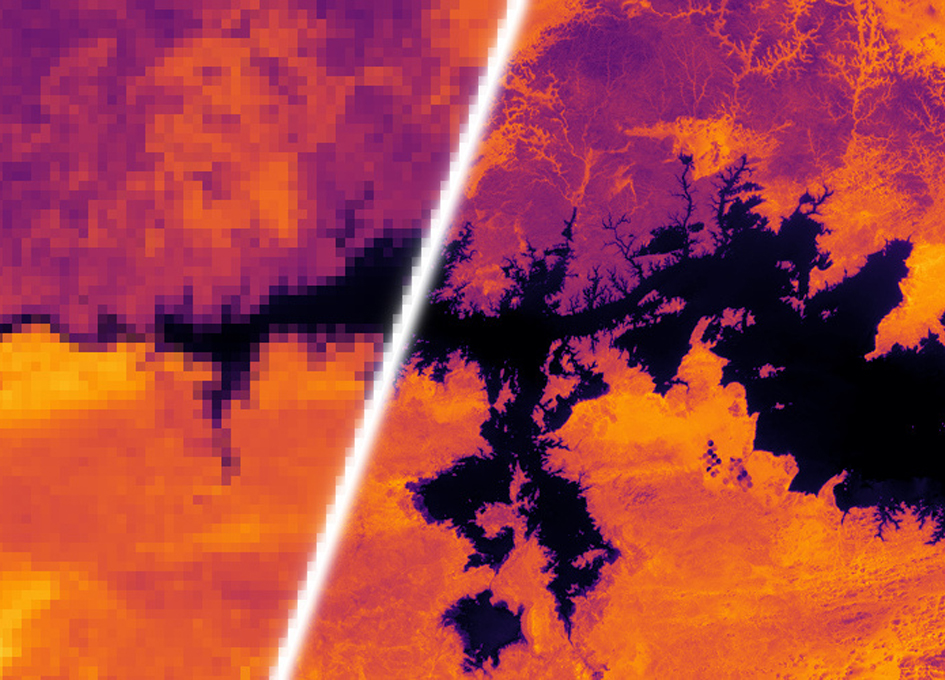

In [2]:
from IPython.display import Image
Image("/kaggle/input/probav-report-images/lr_to_hr.jpg")


<a id="Problem" ></a>

<a id="Problem"></a>
# Problem Statement

PROBA-V payload sensors allow for an almost global coverage (90%) per day, providing 300m resolution images. PROBA-V also provides 100m "high resolution" images, but at a lower frequency, of roughly every 5 days (dependent on the location).

The goal of this challenge is to construct such high-resolution images by fusion of the more frequent 300m images. This process, which is known as Multi-image Super-resolution has already been applied to satellite before: some of these satellites, such as SPOT-VGT or ZY-3 TLC, have payloads that are able to take multiple images of the same area during a single satellite pass, which creates a most favorable condition for the use of super resolution algorithms as images are taken simultaneously. Thus, the super resolution can already be included in the final product of these satellites during post-processing on the ground. However, this is not the case for PROBA-V or other satellites, which could benefit from a post-acquisition enhancement. In those cases, multiple images from the same patch are still available, but originate from successive revisits over longer periods of time.

Thus, PROBA-Vs products represent a convenient way to explore super-resolution in a relevant setting. The images provided for this challenge are not artificially degraded, but are real images recorded from the very same scene, just at different resolutions and different times. Any improvements on this data-set might be transferable to larger collections of remote sensing data without the need to deploy more expensive sensors or satellites, as resolution enhancement can happen post-acquisition.  
  
  Source: [Kelvins-PROBA-V Challenge](https://kelvins.esa.int/proba-v-super-resolution/problem/).  
  
The image shown below depicts the task that we need to perform.

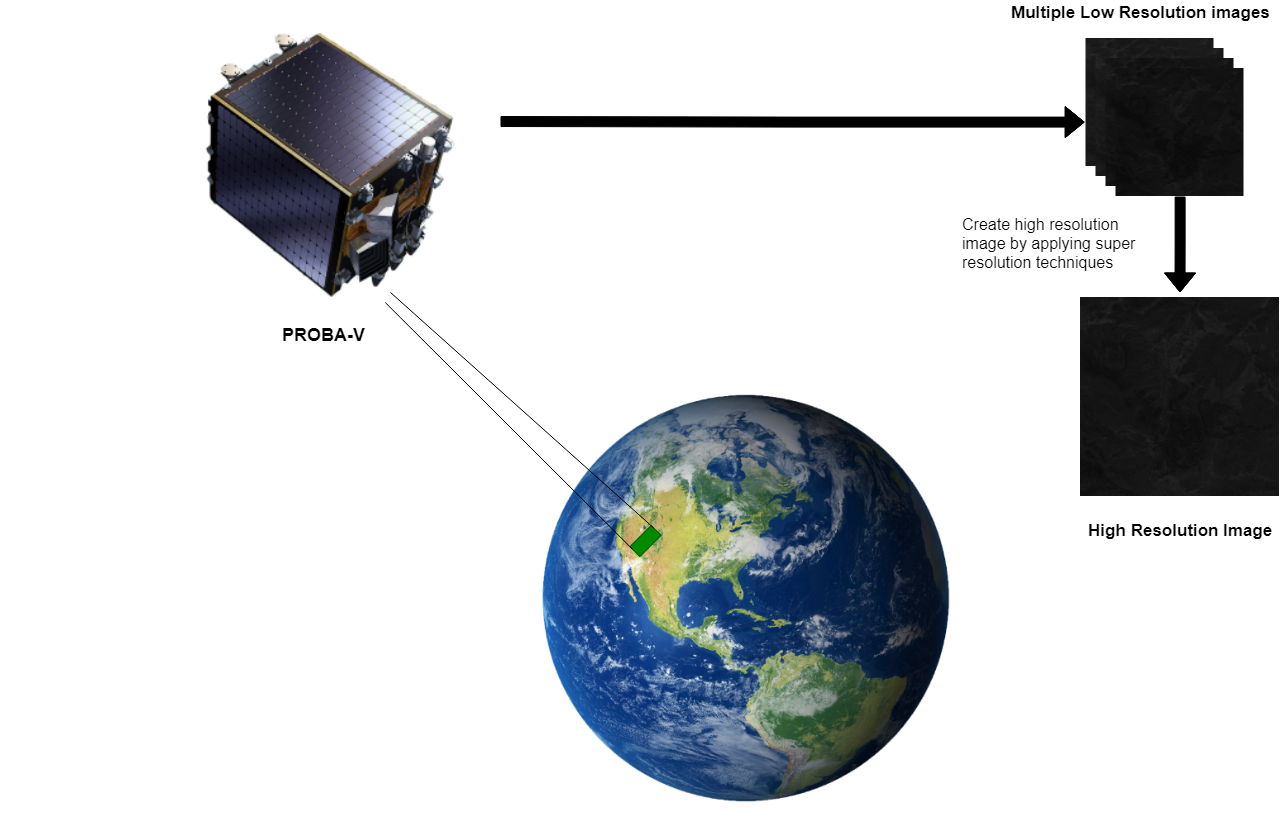

In [3]:
from IPython.display import Image
Image("/kaggle/input/probav-report-images/Proba-v process.png")

## Utility Code

The utility code below, is taken from embiggen module which made available on github by a PROBA-V challenge participant.  
Source: [EMBIGGEN](https://github.com/lfsimoes/probav)

In [4]:
# [============================================================================]


def baseline_upscale(path):
	"""
	Reimplementation of the image enhancement operation performed by the
	baseline code (`generate_sample_submission.py`) provided in:
	https://kelvins.esa.int/proba-v-super-resolution/submission-rules/
	
		"takes all low resolution images that have the maximum amount of clear
		pixels, computes a bicubic upscaling by a factor of 3 and averages their
		pixel intensities."
	
	This function takes as argument the `path` to a single scene, and returns
	the matrix with the scene's enhanced image.
	"""
	clearance = {}
	for (l, c) in lowres_image_iterator(path, img_as_float=True):
		clearance.setdefault(c.sum(), []).append(l)
	
	# take all the images that have the same maximum clearance
	imgs = max(clearance.items(), key=lambda i: i[0])[1]
	
	sr = np.mean([
		bicubic_upscaling(i)
		for i in imgs
		], axis=0)
	
	return sr
	


def central_tendency(images, agg_with='median',
	                 only_clear=False, fill_obscured=False,
	                 img_as_float=True):
	"""
	Aggregate the given `images` through a statistical central tendency measure,
	chosen by setting `agg_with` to either 'mean', 'median' or 'mode'.
	
	Expects `images` to be a list of `(image, status map)` tuples.
	Should `images` be a string, it's interpreted as the path to a scene's
	files. The code will then aggregate that scene's low resolution images
	(LR*.png), while taking also into account their status maps (QM*.png).
	
	Will optionally aggregate only images' clear pixels (if `only_clear=True`)
	by using the information in images' corresponding status maps.
	
	In some scenes, some pixels are obscured in all of the low-resolution
	images. Aggregation with mean/median will return np.nan for those pixels,
	and aggregation with mode will return 0.0.
	If called with `fill_obscured=True` those pixels will be filled with the
	`agg_with` aggregate of the values at all those obscured pixels. Setting
	`fill_obscured` to one of 'mean', 'median' or 'mode' will indicate that is
	the measure that should be used to aggregate obscured pixels.
	"""
	agg_opts = {
		'mean'   : lambda i: np.nanmean(i, axis=0),
		'median' : lambda i: np.nanmedian(i, axis=0),
		'mode'   : lambda i: scipy.stats.mode(i, axis=0, nan_policy='omit').mode[0],
		}
	agg = agg_opts[agg_with]
	
	imgs = []
	obsc = []
	
	if isinstance(images, str):
		images = lowres_image_iterator(images, img_as_float or only_clear)
	elif only_clear:
		# Images were given by the caller, rather than loaded here.
		# Because `only_clear=True`, we generate copies of all lr images, so the
		# function will have no unintended side-effects on the caller's side.
		images = [(l.copy(), c) for (l,c) in images]
	
	for (l, c) in images:
		
		if only_clear:
			
			# keep track of the values at obscured pixels
			if fill_obscured != False:
				o = l.copy()
				o[c] = np.nan
				obsc.append(o)
			
			# replace values at obscured pixels with NaNs
			l[~c] = np.nan
		
		imgs.append(l)
	
	# aggregate the images
	with np.warnings.catch_warnings():   ## https://stackoverflow.com/a/29348184
		# suppress the warnings that originate when `only_clear=True`
		# but some pixels are never clear in any of the images
		np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
		np.warnings.filterwarnings('ignore', r'Mean of empty slice')
		
		agg_img = agg(imgs)
		
		if only_clear and fill_obscured != False:
			if isinstance(fill_obscured, str):
				agg = agg_opts[fill_obscured]
			some_clear = np.isnan(obsc).any(axis=0)
			obsc = agg(obsc)
			obsc[some_clear] = 0.0
			np.nan_to_num(agg_img, copy=False)
			agg_img += obsc
	
	return agg_img


from collections import Counter, defaultdict
from scipy.stats import percentileofscore

# from .aggregate import central_tendency
# from .score import score_image_fast, hr_crops
# from .io import highres_image, scene_id



# [============================================================================]


def describe(data, **kwargs):
	"""
	Generates descriptive statistics that summarize the central tendency,
	dispersion and shape of a dataset's distribution, excluding NaN values.
	
	Basic wrapper to pandas' `describe()`, to which extra arguments are
	redirected. See:
	https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html
	"""
	df = pd.DataFrame(data).describe(**kwargs)
	df.columns = ['']
	return df
	


def cdf_plot(x, **kwargs):
	"""
	Empirical Cumulative Distribution Function.
	https://en.wikipedia.org/wiki/Empirical_distribution_function
	"""
	n = np.arange(1, len(x) + 1) / np.float(len(x))
	plt.step(np.sort(x), n, **kwargs)
	plt.title('Empirical Cumulative Distribution Function')
	plt.xlabel('X')
	plt.ylabel('Cumulative probability')
	


def score_summary(*score_sets, labels=None, **kwargs):
	"""
	Generate a table of summary statistics and an empirical cumulative
	distribution plot for one or more result sets.
	
	Examples
	--------
	# Statistics for a single set of results, no labels:
	>>> (mean_score, img_scores) = score(sr_imgs, per_image=True)
	>>> score_summary(img_scores)
	
	# Comparison of different named sets of results:
	>>> score_summary(test1_scores, test2_scores, labels=['test 1', 'test 2'])
	
	Labels, if given, must be sent though the `labels` keyword argument.
	"""
	labeled = labels is not None
	if not labeled:
		labels = [''] * len(score_sets)
	if isinstance(labels, str):
		labels = [labels]
	
	assert not labeled or len(score_sets) == len(labels)
	
	with sns.axes_style('darkgrid'):
		with sns.plotting_context('notebook', font_scale=1.025):
			
			for sc, lb in zip(score_sets, labels):
				cdf_plot(sc, label=lb, **kwargs)
			if labeled:
				plt.legend()
			plt.xlabel('cPSNR')
	
	df = pd.DataFrame(list(zip(*score_sets)), columns=labels).describe()
	df.index.name = 'cPSNR'
	return df
	


# [============================================================================]


def create_panel(ncols=2, nrows=1):
	"""
	Initialize a panel with `ncols` columns and `nrows` rows.
	Configures the axes for image display: no ticks, no frame and equal aspect.
	
	Usage example:
	>>> fig, axs = create_panel(2, 2)
	>>> axs.flat[3].imshow(image)
	"""
	ax_cfg = dict(xticks=[], yticks=[], aspect='equal', frame_on=False)
	# additional options at:
	# https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.add_subplot
	
	fig, axs = plt.subplots(nrows, ncols,
	                        figsize=(5 * ncols, 5 * nrows),
	                        subplot_kw=ax_cfg)
	fig.tight_layout()
	
	return fig, axs
	


def compare_images(a, b, d=None):
	"""
	Compare side-by-side the images `a` and `b`.
	Shows on a third panel the squared difference between both, while
	compensating for the bias in brightness.
	"""
	fig, axs = create_panel(ncols=3, nrows=1)
	
	if d is None:
		d = a - b
		d -= np.mean(d)
		d *= d
	
	for ax, img, args in zip(axs.flat,
	                         [a, b, d],
	                         [{}, {}, dict(cmap=plt.cm.gray_r, vmin=0)]):
		
		ax.imshow(img, **args)
	
	return fig, axs
	


def compare_to_hr(sr, scene, only_clear=True):
	"""
	Compare side-by-side a super-resolved image `sr` of a given `scene` and its
	ground-truth (`hr`, the scene's high-resolution image).
	
	Shows on a third panel the squared difference between both, while
	compensating for the bias in brightness (`b`). Conceals by default
	(`only_clear=True`) the pixels that are obscured in the `hr` image and don't
	therefore interfere in the determination of `sr`'s cPSNR.
	
	Applies the same registration process that is employed by the competition's
	scoring function, which means the displayed images have a total of 6 pixels
	cropped along the edges in each dimension.
	
	The scene's cPSNR value shown on the left panel relates to the (rounded)
	`mean` value on the right panel (if `only_clear=True`) as:
	>>> baseline_cPSNR.loc[scene_id(scene)] / (-10. * np.log10(mean))
	"""
	(hr, sm) = highres_image(scene)
	
	sr_score = score_image_fast(sr, scene, (hr, sm))
	
	# image registration
	sr = sr[3 : -3, 3 : -3]
	min_cmse = None
	for (_hr, _sm) in hr_crops(hr, sm):
		d = _hr - sr
		if only_clear:
			d[~_sm] = np.nan
		d -= np.nanmean(d)
		d *= d
		m = np.nanmean(d)
		if min_cmse is None or m < min_cmse[0]:
			min_cmse = (m, d, _hr)
	(m, d, hr) = min_cmse
	
	fig, axs = compare_images(sr, hr, d)
	
	axs[0].set_title('super-resolved image, cPSNR: %.4f' % sr_score)
	axs[1].set_title('high-resolution image (ground-truth)')
	axs[2].set_title('(hr - sr - b)^2\n' + \
		'mean: %.2e, std: %.2e, max: %.2e' % (m, np.nanstd(d), np.nanmax(d)),
		fontdict=dict(verticalalignment='center'))
	
	# display the scene's id to the left of the image
	axs[0].text(-.01, 0.5, scene_id(scene, incl_channel=True),
		horizontalalignment='right',
		verticalalignment='center',
		rotation='vertical',
		transform=axs[0].transAxes)
	
	return fig, axs
	


# [============================================================================]


def compare_aggregates(img_path,
	                   type_opts=('mean', 'median', 'mode'),
	                   clear_opts=(False, True),
	                   fill_opts=(False, True)):
	"""
	Plot side-by-side the mean/median/mode aggregations of all images in a given
	scene. Also compares aggregation with and without occluded pixels.
	"""
	figs = []
	
	for only_clear in clear_opts:
		for fill_obscured in (fill_opts if only_clear else [False]):
			
			fig = plt.figure(figsize=(5 * len(type_opts), 6))
			figs.append(fig)
			
			for i, agg_type in enumerate(type_opts):
				
				args = (agg_type, only_clear, fill_obscured)
				img = central_tendency(img_path, *args)
				
				ax = fig.add_subplot(1, len(type_opts), i + 1)
				ax.imshow(img)
				ax.set_title(agg_type)
				ax.axis('off')
			
			t = 'only_clear=%s' % str(only_clear)
			if only_clear:
				t += ', fill_obscured=%s' % str(fill_obscured)
			fig.suptitle(t)
			fig.tight_layout()
	
	return figs


# [============================================================================]


def highres_image(path, img_as_float=True):
	"""
	Load a scene's high resolution image and its corresponding status map.
	
	Returns a `(hr, sm)` tuple, where:
	* `hr`: matrix with the loaded high-resolution image (values as np.uint16 or
	        np.float64 depending on `img_as_float`),
	* `sm`: the image's corresponding "clear pixel?" boolean mask.
	
	Scenes' image files are described at:
	https://kelvins.esa.int/proba-v-super-resolution/data/
	"""
	path = path if path[-1] in {'/', '\\'} else (path + '/')
	hr = skimage.io.imread(path + 'HR.png')
	sm = skimage.io.imread(path + 'SM.png')
	if img_as_float:
		hr = skimage.img_as_float64(hr)
	return (hr, sm)
	


def lowres_image_iterator(path, img_as_float=True):
	"""
	Iterator over all of a scene's low-resolution images (LR*.png) and their
	corresponding status maps (QM*.png).
	
	Returns at each iteration a `(l, c)` tuple, where:
	* `l`: matrix with the loaded low-resolution image (values as np.uint16 or
	       np.float64 depending on `img_as_float`),
	* `c`: the image's corresponding "clear pixel?" boolean mask.
	
	Scenes' image files are described at:
	https://kelvins.esa.int/proba-v-super-resolution/data/
	"""
	path = path if path[-1] in {'/', '\\'} else (path + '/')
	for f in glob(path + 'LR*.png'):
		q = f.replace('LR', 'QM')
		l = skimage.io.imread(f)
		c = skimage.io.imread(q)
		if img_as_float:
			l = skimage.img_as_float64(l)
		yield (l, c)
	


# [============================================================================]


def check_img_as_float(img, validate=True):
	"""
	Ensure `img` is a matrix of values in floating point format in [0.0, 1.0].
	Returns `img` if it already obeys those requirements, otherwise converts it.
	"""
	if not issubclass(img.dtype.type, np.floating):
		img = skimage.img_as_float64(img)
	# https://scikit-image.org/docs/dev/api/skimage.html#img-as-float64
	
	if validate:
		# safeguard against unwanted conversions to values outside the
		# [0.0, 1.0] range (would happen if `img` had signed values).
		assert img.min() >= 0.0 and img.max() <= 1.0
	
	return img
	


# [============================================================================]


def all_scenes_paths(base_path):
	"""
	Generate a list of the paths to all scenes available under `base_path`.
	"""
	base_path = base_path if base_path[-1] in {'/', '\\'} else (base_path + '/')
	return [
		base_path + c + s
		for c in ['RED/', 'NIR/']
		for s in sorted(os.listdir(base_path + c))
		]
	


def scene_id(scene_path, incl_channel=False):
	"""
	Extract from a scene's path its unique identifier.
	
	Examples
	--------
	>>> scene_id('probav/train/RED/imgset0559/')
	'imgset0559'
	>>> scene_id('probav/train/RED/imgset0559', incl_channel=True)
	'RED/imgset0559'
	"""
	sep = os.path.normpath(scene_path).split(os.sep)
	if incl_channel:
		return '/'.join(sep[-2:])
	else:
		return sep[-1]
	


# [============================================================================]


def prepare_submission(images, scenes, subm_fname='submission.zip'):
	"""
	Prepare a set of images for submission.
	
	Given a list of `images` (as matrices of shape (384, 384)), and the paths
	to the `scenes` to which they correspond, write a zip file containing all
	images as .png files, named after their scene's identification
	(example: imgset1160.png).
	"""
	assert len(images) == 290, '%d images provided, 290 expected.' % len(images)
	assert len(images) == len(scenes), "Mismatch in number of images and scenes."
	assert subm_fname[-4:] == '.zip'
	
	# specific warnings we wish to ignore
	warns = [
		'tmp.png is a low contrast image',
		'Possible precision loss when converting from float64 to uint16']
	
	with np.warnings.catch_warnings():
		for w in warns:
			np.warnings.filterwarnings('ignore', w)
		
		print('Preparing submission. Writing to "%s".' % subm_fname)
		
		with ZipFile(subm_fname, mode='w') as zf:
			
			for img, scene in zip(tqdm(images), scenes):
				assert img.shape == (384, 384), \
					'Wrong dimensions in image for scene %s.' % scene
				
				skimage.io.imsave('tmp.png', img)
				zf.write('tmp.png', arcname=scene_id(scene) + '.png')
		
		os.remove('tmp.png')
        
# Baseline cPSNR values for the dataset's images. Used for normalizing scores.
# (provided by the competition's organizers)
baseline_cPSNR = pd.read_csv('/kaggle/input/probav-superresolution/probav_data/norm.csv',
	names = ['scene', 'cPSNR'],
	index_col = 'scene',
	sep = ' ')
	


# [============================================================================]


def score_images(imgs, scenes_paths, *args):
	"""
	Measure the overall (mean) score across multiple super-resolved images.
	
	Takes as input a sequence of images (`imgs`), a sequence with the paths to
	the corresponding scenes (`scenes_paths`), and optionally a sequence of
	(hr, sm) tuples with the pre-loaded high-resolution images of those scenes.
	"""
	return np.mean([
#		score_image(*i)
		score_image_fast(*i)
		for i in zip(tqdm(imgs), scenes_paths, *args)
		])
	


def score_image(sr, scene_path, hr_sm=None):
	"""
	Calculate the individual score (cPSNR, clear Peak Signal to Noise Ratio) for
	`sr`, a super-resolved image from the scene at `scene_path`.
	
	Parameters
	----------
	sr : matrix of shape 384x384
		super-resolved image.
	scene_path : str
		path where the scene's corresponding high-resolution image can be found.
	hr_sm : tuple, optional
		the scene's high resolution image and its status map. Loaded if `None`.
	"""
	hr, sm = highres_image(scene_path) if hr_sm is None else hr_sm
	
	# "We assume that the pixel-intensities are represented
	# as real numbers ∈ [0,1] for any given image."
	sr = check_img_as_float(sr)
	hr = check_img_as_float(hr, validate=False)
	
	# "Let N(HR) be the baseline cPSNR of image HR as found in the file norm.csv."
	N = baseline_cPSNR.loc[scene_id(scene_path)][0]
	
	# "To compensate for pixel-shifts, the submitted images are
	# cropped by a 3 pixel border, resulting in a 378x378 format."
	sr_crop = sr[3 : -3, 3 : -3]
	
	crop_scores = []
	
	for (hr_crop, sm_crop) in hr_crops(hr, sm):
		# values at the cropped versions of each image that
		# fall in clear pixels of the cropped `hr` image
		_hr = hr_crop[sm_crop]
		_sr = sr_crop[sm_crop]
		
		# "we first compute the bias in brightness b"
		pixel_diff = _hr - _sr
		b = np.mean(pixel_diff)
		
		# "Next, we compute the corrected clear mean-square
		# error cMSE of SR w.r.t. HR_{u,v}"
		pixel_diff -= b
		cMSE = np.mean(pixel_diff * pixel_diff)
		
		# "which results in a clear Peak Signal to Noise Ratio of"
		cPSNR = -10. * np.log10(cMSE)
		
		# normalized cPSNR
		crop_scores.append(N / cPSNR)
#		crop_scores.append(cMSE)
	
	# "The individual score for image SR is"
	sr_score = min(crop_scores)
#	sr_score = N / (-10. * np.log10(min(crop_scores)))
	
	return sr_score
	


# [===================================]


def hr_crops(hr, sm):
	"""
	"We denote the cropped 378x378 images as follows: for all u,v ∈ {0,…,6},
	HR_{u,v} is the subimage of HR with its upper left corner at coordinates
	(u,v) and its lower right corner at (378+u, 378+v)."
	-- https://kelvins.esa.int/proba-v-super-resolution/scoring/
	"""
	num_cropped = 6
	max_u, max_v = np.array(hr.shape) - num_cropped
	
	for u in range(num_cropped + 1):
		for v in range(num_cropped + 1):
			yield hr[u : max_u + u, v : max_v + v], \
				  sm[u : max_u + u, v : max_v + v]
	


# [============================================================================]


def score_image_fast(sr, scene_path, hr_sm=None):
	"""
	Calculate the individual score (cPSNR, clear Peak Signal to Noise Ratio) for
	`sr`, a super-resolved image from the scene at `scene_path`.
	
	Parameters
	----------
	sr : matrix of shape 384x384
		super-resolved image.
	scene_path : str
		path where the scene's corresponding high-resolution image can be found.
	hr_sm : tuple, optional
		the scene's high resolution image and its status map. Loaded if `None`.
	"""
	hr, sm = highres_image(scene_path) if hr_sm is None else hr_sm
	
	# "We assume that the pixel-intensities are represented
	# as real numbers ∈ [0,1] for any given image."
	sr = check_img_as_float(sr)
	hr = check_img_as_float(hr, validate=False)
	
	# "Let N(HR) be the baseline cPSNR of image HR as found in the file norm.csv."
	N = baseline_cPSNR.loc[scene_id(scene_path)][0]
	
	return score_against_hr(sr, hr, sm, N)
	


@numba.jit('f8(f8[:,:], f8[:,:], b1[:,:], f8)', nopython=True, parallel=True)
def score_against_hr(sr, hr, sm, N):
	"""
	Numba-compiled version of the scoring function.
	"""
	num_cropped = 6
	max_u, max_v = np.array(hr.shape) - num_cropped
	
	# "To compensate for pixel-shifts, the submitted images are
	# cropped by a 3 pixel border, resulting in a 378x378 format."
	c = num_cropped // 2
	sr_crop = sr[c : -c, c : -c].ravel()
	
	# create a copy of `hr` with NaNs at obscured pixels
	# (`flatten` used to bypass numba's indexing limitations)
	hr_ = hr.flatten()
	hr_[(~sm).ravel()] = np.nan
	hr = hr_.reshape(hr.shape)
	
#	crop_scores = []
	cMSEs = np.zeros((num_cropped + 1, num_cropped + 1), np.float64)
	
	for u in numba.prange(num_cropped + 1):
		for v in numba.prange(num_cropped + 1):
			
			# "We denote the cropped 378x378 images as follows: for all u,v ∈
			# {0,…,6}, HR_{u,v} is the subimage of HR with its upper left corner
			# at coordinates (u,v) and its lower right corner at (378+u, 378+v)"
			hr_crop = hr[u : max_u + u, v : max_v + v].ravel()
			
			# "we first compute the bias in brightness b"
			pixel_diff = hr_crop - sr_crop
			b = np.nanmean(pixel_diff)
			
			# "Next, we compute the corrected clear mean-square
			# error cMSE of SR w.r.t. HR_{u,v}"
			pixel_diff -= b
			pixel_diff *= pixel_diff
			cMSE = np.nanmean(pixel_diff)
			
			# "which results in a clear Peak Signal to Noise Ratio of"
#			cPSNR = -10. * np.log10(cMSE)
			
			# normalized cPSNR
#			crop_scores.append(N / cPSNR)
			
			cMSEs[u, v] = cMSE
	
	# "The individual score for image SR is"
#	sr_score = min(crop_scores)
	sr_score = N / (-10. * np.log10(cMSEs.min()))
	
	return sr_score
	


# [============================================================================]


class scorer(object):
	
	def __init__(self, scene_paths, preload_hr=True):
		"""
		Wrapper to `score_image()` that simplifies the scoring of multiple
		super-resolved images.
		
		The scenes over which the scorer will operate should be given in
		`scene_paths`. This is either a sequence of paths to a subset of scenes
		or a string with a single path. In this case, it is interpreted as the
		base path to the full dataset, and `all_scenes_paths()` will be used to
		locate all the scenes it contains.
		
		Scene paths are stored in the object's `.paths` variable.
		When scoring, only the super-resolved images need to be provided.
		They are assumed to be in the same order as the scenes in `.paths`.
		
		If the object is instantiated with `preload_hr=True` (the default),
		all scene's high-resolution images and their status maps will be
		preloaded. When scoring they will be sent to `score_image()`, thus
		saving computation time in repeated scoring, at the expense of memory.
		"""
		if isinstance(scene_paths, str):
			self.paths = all_scenes_paths(scene_paths)
		else:
			self.paths = scene_paths
		
		self.hr_sm = [] if not preload_hr else [
			highres_image(scn_path, img_as_float=True)
			for scn_path in tqdm(self.paths, desc='Preloading hi-res images')]
		
		self.scores = []
		
	
	def __call__(self, sr_imgs, per_image=False, progbar=True, desc=''):
		"""
		Score all the given super-resolved images (`sr_imgs`), which correspond
		to the scenes at the matching positions of the object's `.paths`.
		
		Returns the overall score (mean normalized cPSNR).
		
		An additional value is returned if `per_image=True`: a list with each
		image's individual cPSNR score. In either case, this list remains
		available in the object's `.scores` variable until the next call.
		"""
		scenes_paths = tqdm(self.paths, desc=desc) if progbar else self.paths
		hr_sm = [] if self.hr_sm == [] else [self.hr_sm]
		
		self.scores = [
#			score_image(*i)
			score_image_fast(*i)
			for i in zip(sr_imgs, scenes_paths, *hr_sm)]
		
		assert len(self.scores) == len(self.paths)
		
		score = np.mean(self.scores)
		
		if per_image:
			return score, self.scores
		else:
			return score
        
import skimage



# [============================================================================]


def bicubic_upscaling(img):
	"""
	Compute a bicubic upscaling by a factor of 3.
	"""
	r = skimage.transform.rescale(img, scale=3, order=3, mode='edge',
	                              anti_aliasing=False, multichannel=False)
	# NOTE: Don't change these options. They're required by `baseline_upscale`.
	# http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rescale
	# http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp
	return r




def scenes_paths(folder):
    '''
    This function returns the paths of all the files present in the given folder

    Parameters:
    ----------------------------------------------------------------------------
    folder : String
            folder path to all the scenes in the dataset
    '''
    if folder[-1:] == '/':
        folder = folder[:-1]
    sub_folders = ['/RED/', '/NIR/'] #All scenes are divided in two folders namely RED and NIR
    paths = []
    for sub in sub_folders:
        path = folder + sub
        for scene in (os.listdir(path)):
            paths.append(path + scene)
    return paths


def get_lr_images(scene_path):
    '''
    This function returns an iterator for the low resolution images and their respective status masks for a given scene

    Parameters:
    ----------------------------------------------------------------------------
    scene_path : String
            path to scene to get get the low resolution images for
    '''
    lr_images = []
    qm_images = []
    for image_file_path in glob(scene_path + '/LR*.png'):
        mask_file_path = image_file_path.replace('LR', 'QM')
        lr_images.append(cv2.imread(image_file_path, 0))
        qm_images.append(cv2.imread(mask_file_path, 0))
    lr_images = lr_images[:9]
    qm_images = qm_images[:9]
    return(lr_images, qm_images)




def get_hr_image(scene_path):
    '''
    This function returns the high resolution image and its respective status mask foe the given scene

    Parameters:
    ----------------------------------------------------------------------------
    scene_path : String
            path to scene to get high resolution image for
    '''
    hr_image = cv2.imread(scene_path + '/HR.png', 0)
    sm_image = cv2.imread(scene_path + '/SM.png', 0)
    return (hr_image, sm_image)

<a id="Data"></a>

<a id="Data"></a>
# Data

#### Origin of the data
We collected satellite data from the PROBA-V mission of the European Space Agency from 74 hand-selected regions around the globe at different points in time. The data is composed of radiometrically and geometrically corrected Top-Of-Atmosphere (TOA) reflectances for the RED and NIR spectral bands at 300m and 100m resolution in Plate Carrée projection. The 300m resolution data is delivered as 128x128 grey-scale pixel images, the 100m resolution data as 384x384 grey-scale pixel images. The bit-depth of the images is 14, but they are saved in a 16-bit .png-format (which makes them look relatively dark if opened in typical image viewers).

Each image comes with a quality map, indicating which pixels in the image are concealed (i.e. clouds, cloud shadows, ice, water, missing, etc) and which should be considered clear. For an image to be included in the dataset, at least 75% of its pixels have to be clear for 100m resolution images, and 60% for 300m resolution images. Each data-point consists of exactly one 100m resolution image and several 300m resolution images from the same scene. In total, the dataset contains 1450 scenes, which are split into 1160 scenes for training and 290 scenes for testing. On average, each scene comes with 19 different low resolution images and always with at least 9. We expect you to submit a 384x384 image for each of the 290 test-scenes, for which we will not provide a high resolution image.

#### Changes in landscape
The images have been recorded within a time window of 30 days. As such, the scenes are not always permanent but can change marginally.

#### Image registration
The images are delivered as recorded by PROBA-V and have not been modified to align with each other. While the mean geolocation accuracy of PROBA-V is about 61m, (sub)-pixelshifts in the content occur and are - in a sense - necessary to perform super-resolution. Thus, the dataset itself is not corrected for these shifts and none of the images are registered to each other. The scoring will take pixel-shifts of the high resolution image into account, as registration cannot be computed by the participant for the test-set.

Source: [https://kelvins.esa.int/proba-v-super-resolution/data/](https://kelvins.esa.int/proba-v-super-resolution/data/)

<a id='EDA'></a>

<a id="EDA"></a>
### Exploratory  Data Analysis


There are atmost 19 low-resolution images and atleast 9 low-resolution images available for every given scene in the dataset, along with their **clearance mask** which tells us, which pixels in the image are obscured due to some artifact or some glitch. For every scene, we are also given a high-Resolution image(our target image 'HR.png') and a clearance map for the high-resolution image.

Below we display some examples of all low-resolution, high-resolution images, and their clearance masks.

In [5]:
# save the train images directory, which is all we will be using for our model as we don't have high resolution images 
# for the images present in test dataset

train_path = '/kaggle/input/probav-superresolution/probav_data/train'

# Extract all the scenes paths and make a list
train = all_scenes_paths(train_path)

baseName = '/kaggle/input/probav-superresolution/probav_data/'

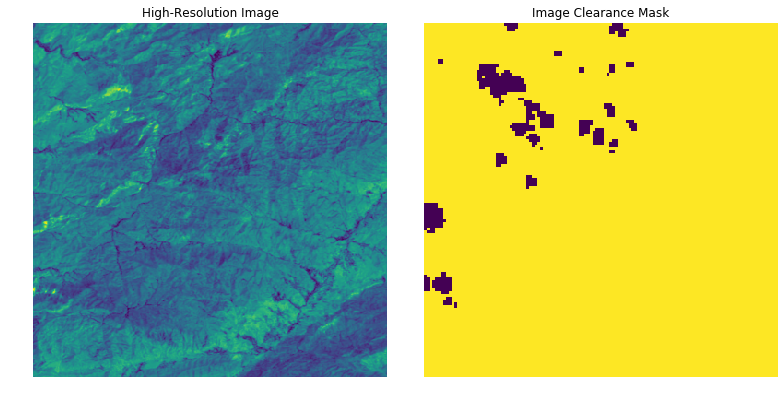

In [6]:
# Get the high resolution image and its mask for the scene '0348'
hr, sm = highres_image(baseName + 'train/RED/imgset0348')


#### Plot the high resolution image along with the mask of the same scne hr image '0348'

# HR image
fig = plt.figure(figsize=(11,11))
ax1 = fig.add_subplot(121)
ax1.imshow(hr)
ax1.set_title('High-Resolution Image')
ax1.axis('off')

#HR image mask
ax2 = fig.add_subplot(122)
ax2.imshow(sm)
ax2.axis('off')
ax2.set_title('Image Clearance Mask')
plt.tight_layout()

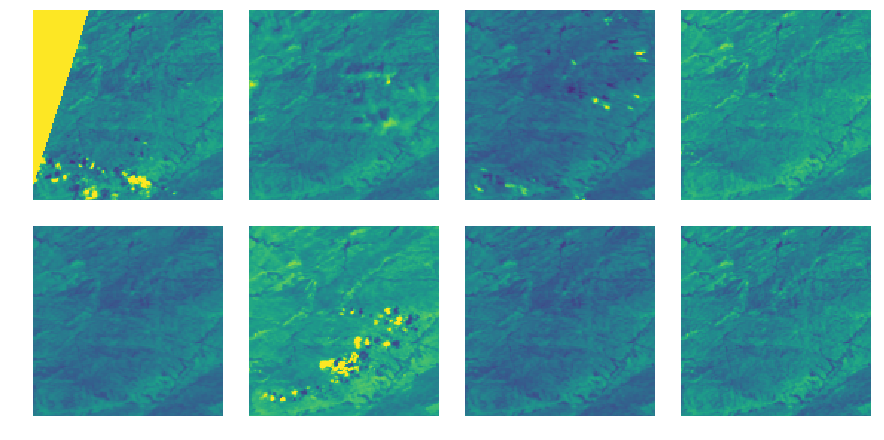

In [7]:
#### Plot the low resolution images present fot the given scene ex. scene '0348'

fig = plt.figure(figsize=(12, 6))

i = 0

# Extract the low resolution images and their masks, and display only the low-resolution images
for (lr, sm) in lowres_image_iterator(baseName + 'train/RED/imgset0348'):
    
    i += 1
    ax = fig.add_subplot(2, 4, i)
    ax.axis('off')
    
    ax.imshow(lr, vmin=0, vmax=0.2)
    
    if i == 8: break

# Eight images are plotted
fig.tight_layout(pad=0)

<a id="Analysis"></a>
# Analysis

First, I needed some domain knowledge of how super-resolution works. Although I knew about what super-resolution is and have thought about how low resoltuion images can be converted to high resolution images, I needed some technical details on how super-resolution can be performed and does it match with my previous hypothesis that I have maintained in my head, and therefore first I watched some videos on super-resolution to understand the technical details better and I also read some blogs on the topic.  
* [Deep Learning for Image Super-Resolution](https://www.youtube.com/watch?v=ppsqbOL073U&t=61s)
* [Enhance! Super Resolution From Google | Two Minute Papers #124](https://www.youtube.com/watch?v=WovbLx8C0yA)
* [An Introduction to Super Resolution using Deep Learning](https://medium.com/beyondminds/an-introduction-to-super-resolution-using-deep-learning-f60aff9a499d)
* [Deconvolution](youtube.com/watch?v=Xk7myx9_OmU)  
* [Deconvolutional Microscopy](https://www.youtube.com/watch?v=MJ2FOFqr7hw&t=12s)

There are mainly two different types of methods of super-resolution that can be performed, they are:
1. Single Image Super-Resolution
1. Multi Image Super-Resolution


After my analysis to understand the problem and techniques to solve it, I went through some of the latest research papers in the domain.  

FSRCNN, SRGAN, CSFM, and the winning model of the Kelvin PROBA-V Challenge **DeepSUM**.  

* DeepSUM is large and difficult to implement in the given timeframe, and hence I didn't dig deep into it.


These two below models are the one I studied in deep because they covered two different aspects and methods of doing super-resolution.

| Model | Technique | Date Released |
| --- | --- | --- |
| FSRCNN | Fast Super-Resolution Convolutional Neural Network | 2016 |  
| SRGAN | Super-Resolution Generative Adversarial Network | 2017 |  


  
  These two above methods are single image super resolution methods, which we modify a little bit to work for completing our task. We will be constructing a model based on FSRCNN, with some minor changes.  

#### FSRCNN

Fast Super-Resolution CNN is an advanced method to speed up the SRCNN super-resolution method. **In case of SRCNN** the input images need to be upscaled by the required factor before feeding it to the neural network and then consecutive convolutions are done to enhance the image quality to match the target high-resolution image. This upscaling method and then enhancing the quality takes high amount of time. To address this time problem, FSRCNN came into existance; FSRCNN doesn't upscale  the input image initally and input the low-resolution image to the network as it is, then multiple convolutions are done on the image: **Feature Exraction, Shrinking, Mapping, Expanding** and finally a **Deconvolution** is performed on the image (Transpose Convolution actually) to upscale the image by the given factor.


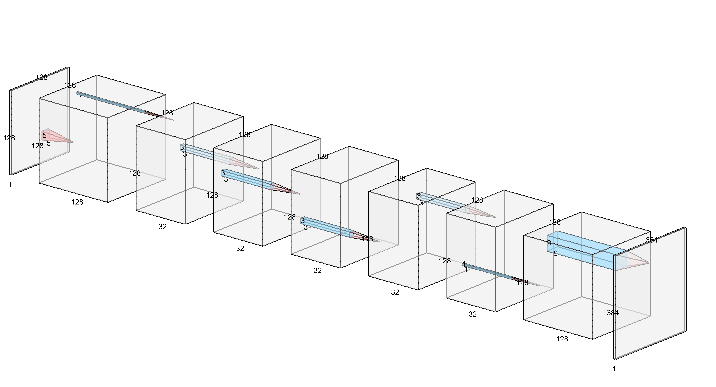

In [8]:
from IPython.display import Image
Image("/kaggle/input/probav-report-images/model_structure.png")


![](http://)The image below shows **two different methods** I thought I could follow to get our task done. In my implementation, I have used the method on **right** i.e. I have combined all the low resolution in a single image by taking median of each pixel in the image, which gave us a cloud artifacts free image.


<a id="MultiISR"></a>

***NOTE:***  I also tried a **different method**, shown on the left side in the image below for **super-resolution that is purely multi-image,** but **unfortunately I was not able to get expected results** due to time contraints and system constraints which made me stop doing other experiments.  
The method is like this:  

* Instead of using a median image as input, I tried to use multiple low-resolution images(9 because atleast 9 images in each scene are  available) by **stacking them on top of each other as channels**, and then feeding it to the model.  
* The model then perform multiple convolutions on the image stack and learn features from all the channels(images), which eventually removes all the artifacts and faults in the image.
* Then we combine all the channels into a single channel image.
* Finally, we perform a **deconvolution** on the single channel image we obtained from the previous layer, to scale the image by the erquired factor.

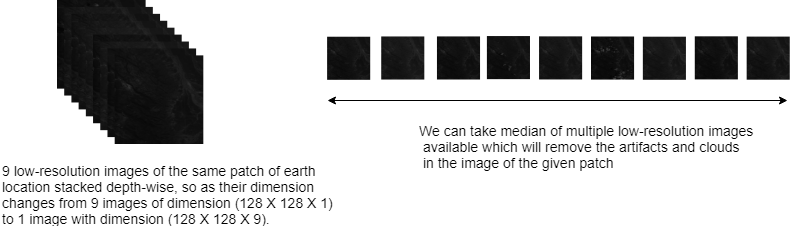

In [9]:
from IPython.display import Image
Image("/kaggle/input/probav-report-images/data.png")

<a id="Implementation"></a>
# Implementation

In [10]:
# We define an iterator for getting images from the directory
from itertools import cycle
def get_scene_images():
    '''
    This is a generator function which loads all the low resolution images, low_resolution images mask, high resolution
    image,and high-resolution image mask for a specific scene and then it creates a single image by combining all the low
    resolution images using the median value for each pixel in all the low-resolution images.
    
    Returns: low-resolution 
    '''
    all_scene_paths = scenes_paths('/kaggle/input/probav-superresolution/probav_data/train')
    for scene in all_scene_paths:
        lr_images, qm_images = get_lr_images(scene)
        lr_images = central_tendency(scene, agg_with='median', only_clear=False)
        hr_image, sm_image = highres_image(scene)
        yield(lr_images, qm_images, hr_image, sm_image)


In [11]:
# create an object of the generator get_scene_images()
scene_images = get_scene_images()

# create a cycle iterator so that it never gets exhausted
scene_images = cycle(scene_images)

def get_next_batch():
    """
    This method returns a new batch of 16 low-resolution and high-resolution images
    """
    lr_images = []
    hr_images = []  
    for i in range(16):
        # Get the images from the generator for the next scene
        lr_image_stack,qm_images,hr_image,sm_image = next(scene_images)
        lr_images.append(lr_image_stack)
        hr_images.append(hr_image)
    lr_images = np.asarray(lr_images)
    hr_images = np.asarray(hr_images)
    return (lr_images, hr_images)



<a id="Implementation"></a>
# FSRCNN Implementation

In [12]:
# Perform all the imports required for our implementation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

In [13]:
#Check if GPU is available in the system or not
torch.cuda.is_available()

# set device to GPU if available otherwise set device to cpu only
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class SuperResolution(nn.Module):
    """
    This is our network model class which defines the structure of our model and the forward function for training and testing 
    the data.
    It has 7 Convolution layers and 1 Deconvolution layer"""
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size = 5, stride = 1, padding = 2)
        self.conv_2 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 1, stride = 1, padding = 0)
        self.conv_3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv_4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv_5 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv_6 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv_7 = nn.Conv2d(in_channels = 32, out_channels = 128, kernel_size = 1, stride = 1, padding = 0)
        self.de_conv_1 = nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=9, stride=3, padding=3, output_padding=0)
        #self.de_conv_2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride=1, padding=2)

    def forward(self, img):
        out = F.relu(self.conv_1(img))
        out = F.relu(self.conv_2(out))
        out = F.relu(self.conv_3(out))
        out = F.relu(self.conv_4(out))
        out = F.relu(self.conv_5(out))
        out = F.relu(self.conv_6(out))
        out = F.relu(self.conv_7(out))
        out = self.de_conv_1(out)
        #out = F.relu(self.de_conv_2(out))
        return out

In [15]:
def get_optimizer(model, learning_rate):
    '''
    This method returns an optimizer (Adam) for a given model and given learning rate
    '''
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    return (optimizer)

In [16]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    '''This method saves a checktoint of the model state if a new best is achieved'''
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        pass

In [17]:
import time

def train(super_model, learning_rate, n_epochs, batch_size):
    """
    This function is defined for pre-processing the data and training the model
    """
    print ("===============MODEL SPECIFICATIONS===============")
    print("Learning rate: {0}".format(learning_rate))
    print("Epochs: {0}".format(n_epochs))
    print("Batch size: {0}".format(batch_size))
   # print(summary(super_model,(9,128,128))) # Print the summary of all layers and parameters in the model
    
    optimizer = get_optimizer(super_model, learning_rate)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[200,300], gamma=0.1)
    is_best = False
    training_start_time = time.time()
    criterion = nn.MSELoss()
    best_loss = 999999
    for e in range(n_epochs):
        print("[INFO]===================")
        print("Epoch: {0}".format(e+1))
        for i in tqdm(range(72)):
            start_time = time.time()
            lr_images, hr_images = get_next_batch()
            lr_images = lr_images.reshape(16, 1,128,128)
            hr_images = hr_images.reshape(16,1,384,384)
            optimizer.zero_grad()
            lr_images = torch.from_numpy(lr_images).float()
            lr_images = lr_images.to(device)
            output = super_model.forward(lr_images)
            output = output.view(16,1,384,384)
            hr_images = torch.from_numpy(hr_images).float()
            hr_images = hr_images.to(device)
            max_val = torch.max(output).item()
            loss = criterion(output, hr_images)
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("Current Loss: {0}".format(loss))
        if (loss < best_loss):
#             print("We got a better loss value")
            is_best = True
            best_loss = loss
        
        save_checkpoint({
        'epoch': n_epochs + 1,
        'state_dict': super_model.state_dict(),
        'optimizer' : optimizer.state_dict(),}, is_best)
        is_best = False
    return best_loss

Now, we create an object of our model class 'SuperResolution' and transfer the models parameters to the CUDA device

In [18]:
# Create an object of the SuperResolution class we have defined (the neural net model class)
super_model = SuperResolution()
super_model.to(device)

SuperResolution(
  (conv_1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_2): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_7): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
  (de_conv_1): ConvTranspose2d(128, 1, kernel_size=(9, 9), stride=(3, 3), padding=(3, 3))
)

Next, we call the train() function to start training the model with our passed parameters as shown below.  

The train function returns the best loss value it acquired while training and saves the model to local disk

In [19]:
# Call the train function on super_model object with learning_rate = 0.001, number_of_epochs = 250, batch_size = 16),
# the train function return the final loss of the model
model_loss = train(super_model,0.001, 250, 16)
 

  0%|          | 0/72 [00:00<?, ?it/s]

===============MODEL SPECIFICATIONS===============
Learning rate: 0.001
Epochs: 250
Batch size: 16
[INFO]===================
Epoch: 1


  0%|          | 0/72 [00:00<?, ?it/s]

Current Loss: 0.0008900862885639071
=> Saving a new best
[INFO]===================
Epoch: 2


  4%|▍         | 3/72 [00:00<00:02, 25.83it/s]

Current Loss: 0.0003609682316891849
=> Saving a new best
[INFO]===================
Epoch: 3


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 0.00029700470622628927
=> Saving a new best
[INFO]===================
Epoch: 4


  4%|▍         | 3/72 [00:00<00:02, 26.22it/s]

Current Loss: 0.00011439385707490146
=> Saving a new best
[INFO]===================
Epoch: 5


  4%|▍         | 3/72 [00:00<00:02, 26.11it/s]

Current Loss: 9.912582754623145e-05
=> Saving a new best
[INFO]===================
Epoch: 6


  4%|▍         | 3/72 [00:00<00:02, 26.42it/s]

Current Loss: 0.0001023387594614178
[INFO]===================
Epoch: 7


  4%|▍         | 3/72 [00:00<00:02, 26.22it/s]

Current Loss: 5.711975245503709e-05
=> Saving a new best
[INFO]===================
Epoch: 8


  4%|▍         | 3/72 [00:00<00:02, 26.26it/s]

Current Loss: 5.3634270443581045e-05
=> Saving a new best
[INFO]===================
Epoch: 9


  4%|▍         | 3/72 [00:00<00:02, 26.34it/s]

Current Loss: 5.810032598674297e-05
[INFO]===================
Epoch: 10


  4%|▍         | 3/72 [00:00<00:02, 26.25it/s]

Current Loss: 7.19742092769593e-05
[INFO]===================
Epoch: 11


  4%|▍         | 3/72 [00:00<00:02, 26.35it/s]

Current Loss: 9.893915557768196e-05
[INFO]===================
Epoch: 12


  4%|▍         | 3/72 [00:00<00:02, 26.18it/s]

Current Loss: 0.00012426028843037784
[INFO]===================
Epoch: 13


  4%|▍         | 3/72 [00:00<00:02, 26.40it/s]

Current Loss: 0.0001623751304578036
[INFO]===================
Epoch: 14


  4%|▍         | 3/72 [00:00<00:02, 26.35it/s]

Current Loss: 0.00016314083768520504
[INFO]===================
Epoch: 15


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 8.295728912344202e-05
[INFO]===================
Epoch: 16


  4%|▍         | 3/72 [00:00<00:02, 25.91it/s]

Current Loss: 0.00010277036199113354
[INFO]===================
Epoch: 17


  4%|▍         | 3/72 [00:00<00:02, 26.37it/s]

Current Loss: 7.63732023187913e-05
[INFO]===================
Epoch: 18


  4%|▍         | 3/72 [00:00<00:02, 26.25it/s]

Current Loss: 7.711254875175655e-05
[INFO]===================
Epoch: 19


  4%|▍         | 3/72 [00:00<00:02, 26.35it/s]

Current Loss: 7.13817571522668e-05
[INFO]===================
Epoch: 20


  4%|▍         | 3/72 [00:00<00:02, 26.30it/s]

Current Loss: 9.796987433219329e-05
[INFO]===================
Epoch: 21


  4%|▍         | 3/72 [00:00<00:02, 26.18it/s]

Current Loss: 8.633793913759291e-05
[INFO]===================
Epoch: 22


  4%|▍         | 3/72 [00:00<00:02, 26.17it/s]

Current Loss: 5.7175380788976327e-05
[INFO]===================
Epoch: 23


  4%|▍         | 3/72 [00:00<00:02, 26.16it/s]

Current Loss: 6.88140862621367e-05
[INFO]===================
Epoch: 24


  4%|▍         | 3/72 [00:00<00:02, 25.77it/s]

Current Loss: 7.536059274571016e-05
[INFO]===================
Epoch: 25


  4%|▍         | 3/72 [00:00<00:02, 26.25it/s]

Current Loss: 6.48548302706331e-05
[INFO]===================
Epoch: 26


  4%|▍         | 3/72 [00:00<00:02, 26.35it/s]

Current Loss: 9.437226253794506e-05
[INFO]===================
Epoch: 27


  4%|▍         | 3/72 [00:00<00:02, 26.33it/s]

Current Loss: 6.485883932327852e-05
[INFO]===================
Epoch: 28


  4%|▍         | 3/72 [00:00<00:02, 26.22it/s]

Current Loss: 8.013066690182313e-05
[INFO]===================
Epoch: 29


  4%|▍         | 3/72 [00:00<00:02, 26.41it/s]

Current Loss: 8.25971073936671e-05
[INFO]===================
Epoch: 30


  4%|▍         | 3/72 [00:00<00:02, 26.30it/s]

Current Loss: 8.04345982032828e-05
[INFO]===================
Epoch: 31


  4%|▍         | 3/72 [00:00<00:02, 26.26it/s]

Current Loss: 8.335620077559724e-05
[INFO]===================
Epoch: 32


  4%|▍         | 3/72 [00:00<00:02, 26.38it/s]

Current Loss: 5.898070230614394e-05
[INFO]===================
Epoch: 33


  4%|▍         | 3/72 [00:00<00:02, 26.39it/s]

Current Loss: 6.312158075161278e-05
[INFO]===================
Epoch: 34


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 5.487672024173662e-05
[INFO]===================
Epoch: 35


  4%|▍         | 3/72 [00:00<00:02, 26.16it/s]

Current Loss: 5.0254649977432564e-05
=> Saving a new best
[INFO]===================
Epoch: 36


  4%|▍         | 3/72 [00:00<00:02, 26.30it/s]

Current Loss: 7.390882819890976e-05
[INFO]===================
Epoch: 37


  4%|▍         | 3/72 [00:00<00:02, 26.36it/s]

Current Loss: 7.360451127169654e-05
[INFO]===================
Epoch: 38


  4%|▍         | 3/72 [00:00<00:02, 26.35it/s]

Current Loss: 4.349980008555576e-05
=> Saving a new best
[INFO]===================
Epoch: 39


  4%|▍         | 3/72 [00:00<00:02, 26.24it/s]

Current Loss: 7.144966366467997e-05
[INFO]===================
Epoch: 40


  4%|▍         | 3/72 [00:00<00:02, 26.32it/s]

Current Loss: 9.279171354137361e-05
[INFO]===================
Epoch: 41


  4%|▍         | 3/72 [00:00<00:02, 26.24it/s]

Current Loss: 6.202488293638453e-05
[INFO]===================
Epoch: 42


  4%|▍         | 3/72 [00:00<00:02, 25.95it/s]

Current Loss: 5.865956700290553e-05
[INFO]===================
Epoch: 43


  4%|▍         | 3/72 [00:00<00:02, 26.33it/s]

Current Loss: 6.797354581067339e-05
[INFO]===================
Epoch: 44


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 0.00010911829303950071
[INFO]===================
Epoch: 45


  4%|▍         | 3/72 [00:00<00:02, 25.82it/s]

Current Loss: 9.403528383700177e-05
[INFO]===================
Epoch: 46


  4%|▍         | 3/72 [00:00<00:02, 26.11it/s]

Current Loss: 5.520327249541879e-05
[INFO]===================
Epoch: 47


  4%|▍         | 3/72 [00:00<00:02, 26.05it/s]

Current Loss: 6.603456131415442e-05
[INFO]===================
Epoch: 48


  4%|▍         | 3/72 [00:00<00:02, 26.17it/s]

Current Loss: 0.00012394679652061313
[INFO]===================
Epoch: 49


  4%|▍         | 3/72 [00:00<00:02, 26.26it/s]

Current Loss: 7.395310240099207e-05
[INFO]===================
Epoch: 50


  4%|▍         | 3/72 [00:00<00:02, 26.21it/s]

Current Loss: 6.435954128392041e-05
[INFO]===================
Epoch: 51


  4%|▍         | 3/72 [00:00<00:02, 26.45it/s]

Current Loss: 8.023726695682853e-05
[INFO]===================
Epoch: 52


  4%|▍         | 3/72 [00:00<00:02, 26.37it/s]

Current Loss: 7.981128874234855e-05
[INFO]===================
Epoch: 53


  4%|▍         | 3/72 [00:00<00:02, 25.58it/s]

Current Loss: 5.523404979612678e-05
[INFO]===================
Epoch: 54


  4%|▍         | 3/72 [00:00<00:02, 26.23it/s]

Current Loss: 7.707597251283005e-05
[INFO]===================
Epoch: 55


  4%|▍         | 3/72 [00:00<00:02, 26.24it/s]

Current Loss: 0.00010185505379922688
[INFO]===================
Epoch: 56


  4%|▍         | 3/72 [00:00<00:02, 26.37it/s]

Current Loss: 0.00011353535956004634
[INFO]===================
Epoch: 57


  4%|▍         | 3/72 [00:00<00:02, 26.41it/s]

Current Loss: 6.582316564163193e-05
[INFO]===================
Epoch: 58


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 8.07914329925552e-05
[INFO]===================
Epoch: 59


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 0.00010620359535096213
[INFO]===================
Epoch: 60


  4%|▍         | 3/72 [00:00<00:02, 26.13it/s]

Current Loss: 7.586599531350657e-05
[INFO]===================
Epoch: 61


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 4.9674792535370216e-05
[INFO]===================
Epoch: 62


  4%|▍         | 3/72 [00:00<00:02, 26.20it/s]

Current Loss: 6.601425411645323e-05
[INFO]===================
Epoch: 63


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 8.094155055005103e-05
[INFO]===================
Epoch: 64


  4%|▍         | 3/72 [00:00<00:02, 26.21it/s]

Current Loss: 5.9824778873007745e-05
[INFO]===================
Epoch: 65


  4%|▍         | 3/72 [00:00<00:02, 26.45it/s]

Current Loss: 6.990072870394215e-05
[INFO]===================
Epoch: 66


  4%|▍         | 3/72 [00:00<00:02, 26.25it/s]

Current Loss: 8.959306433098391e-05
[INFO]===================
Epoch: 67


  4%|▍         | 3/72 [00:00<00:02, 25.86it/s]

Current Loss: 7.635475776623935e-05
[INFO]===================
Epoch: 68


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 5.6097593187587336e-05
[INFO]===================
Epoch: 69


  4%|▍         | 3/72 [00:00<00:02, 26.13it/s]

Current Loss: 4.895370875601657e-05
[INFO]===================
Epoch: 70


  4%|▍         | 3/72 [00:00<00:02, 26.14it/s]

Current Loss: 3.487716821837239e-05
=> Saving a new best
[INFO]===================
Epoch: 71


  4%|▍         | 3/72 [00:00<00:02, 26.22it/s]

Current Loss: 3.4165263059549034e-05
=> Saving a new best
[INFO]===================
Epoch: 72


  4%|▍         | 3/72 [00:00<00:02, 26.39it/s]

Current Loss: 3.0860595870763063e-05
=> Saving a new best
[INFO]===================
Epoch: 73


  4%|▍         | 3/72 [00:00<00:02, 26.26it/s]

Current Loss: 3.627712794695981e-05
[INFO]===================
Epoch: 74


  4%|▍         | 3/72 [00:00<00:02, 26.13it/s]

Current Loss: 4.2825024138437584e-05
[INFO]===================
Epoch: 75


  4%|▍         | 3/72 [00:00<00:02, 26.24it/s]

Current Loss: 3.614811066654511e-05
[INFO]===================
Epoch: 76


  4%|▍         | 3/72 [00:00<00:02, 26.26it/s]

Current Loss: 4.612892371369526e-05
[INFO]===================
Epoch: 77


  4%|▍         | 3/72 [00:00<00:02, 26.33it/s]

Current Loss: 4.89486483274959e-05
[INFO]===================
Epoch: 78


  4%|▍         | 3/72 [00:00<00:02, 26.04it/s]

Current Loss: 2.689068060135469e-05
=> Saving a new best
[INFO]===================
Epoch: 79


  4%|▍         | 3/72 [00:00<00:02, 26.35it/s]

Current Loss: 4.023073415737599e-05
[INFO]===================
Epoch: 80


  4%|▍         | 3/72 [00:00<00:02, 26.49it/s]

Current Loss: 5.552387301577255e-05
[INFO]===================
Epoch: 81


  4%|▍         | 3/72 [00:00<00:02, 25.91it/s]

Current Loss: 7.185651338659227e-05
[INFO]===================
Epoch: 82


  4%|▍         | 3/72 [00:00<00:02, 26.43it/s]

Current Loss: 3.820184792857617e-05
[INFO]===================
Epoch: 83


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 5.093069557915442e-05
[INFO]===================
Epoch: 84


  4%|▍         | 3/72 [00:00<00:02, 26.37it/s]

Current Loss: 5.444323687697761e-05
[INFO]===================
Epoch: 85


  4%|▍         | 3/72 [00:00<00:02, 26.33it/s]

Current Loss: 4.418442404130474e-05
[INFO]===================
Epoch: 86


  4%|▍         | 3/72 [00:00<00:02, 26.22it/s]

Current Loss: 3.4022872569039464e-05
[INFO]===================
Epoch: 87


  4%|▍         | 3/72 [00:00<00:02, 26.20it/s]

Current Loss: 4.305879338062368e-05
[INFO]===================
Epoch: 88


  4%|▍         | 3/72 [00:00<00:02, 26.11it/s]

Current Loss: 4.345459092292003e-05
[INFO]===================
Epoch: 89


  4%|▍         | 3/72 [00:00<00:02, 26.14it/s]

Current Loss: 5.7844426919473335e-05
[INFO]===================
Epoch: 90


  4%|▍         | 3/72 [00:00<00:02, 26.10it/s]

Current Loss: 3.5572698834585026e-05
[INFO]===================
Epoch: 91


  4%|▍         | 3/72 [00:00<00:02, 26.40it/s]

Current Loss: 2.9430990252876654e-05
[INFO]===================
Epoch: 92


  4%|▍         | 3/72 [00:00<00:02, 26.25it/s]

Current Loss: 3.73982620658353e-05
[INFO]===================
Epoch: 93


  4%|▍         | 3/72 [00:00<00:02, 26.22it/s]

Current Loss: 4.792834442923777e-05
[INFO]===================
Epoch: 94


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 3.117295273113996e-05
[INFO]===================
Epoch: 95


  4%|▍         | 3/72 [00:00<00:02, 26.05it/s]

Current Loss: 3.210110298823565e-05
[INFO]===================
Epoch: 96


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 4.622370033757761e-05
[INFO]===================
Epoch: 97


  4%|▍         | 3/72 [00:00<00:02, 26.16it/s]

Current Loss: 4.151037137489766e-05
[INFO]===================
Epoch: 98


  4%|▍         | 3/72 [00:00<00:02, 26.37it/s]

Current Loss: 3.281029057689011e-05
[INFO]===================
Epoch: 99


  4%|▍         | 3/72 [00:00<00:02, 26.34it/s]

Current Loss: 3.7821107980562374e-05
[INFO]===================
Epoch: 100


  4%|▍         | 3/72 [00:00<00:02, 26.19it/s]

Current Loss: 3.454844409134239e-05
[INFO]===================
Epoch: 101


  4%|▍         | 3/72 [00:00<00:02, 26.18it/s]

Current Loss: 2.794530701066833e-05
[INFO]===================
Epoch: 102


  4%|▍         | 3/72 [00:00<00:02, 26.18it/s]

Current Loss: 4.4647535105468705e-05
[INFO]===================
Epoch: 103


  4%|▍         | 3/72 [00:00<00:02, 26.42it/s]

Current Loss: 5.429438533610664e-05
[INFO]===================
Epoch: 104


  4%|▍         | 3/72 [00:00<00:02, 26.17it/s]

Current Loss: 3.2900476071517915e-05
[INFO]===================
Epoch: 105


  4%|▍         | 3/72 [00:00<00:02, 26.45it/s]

Current Loss: 3.274025584687479e-05
[INFO]===================
Epoch: 106


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 5.677915396518074e-05
[INFO]===================
Epoch: 107


  4%|▍         | 3/72 [00:00<00:02, 26.55it/s]

Current Loss: 4.7723664465593174e-05
[INFO]===================
Epoch: 108


  4%|▍         | 3/72 [00:00<00:02, 26.16it/s]

Current Loss: 3.632163134170696e-05
[INFO]===================
Epoch: 109


  4%|▍         | 3/72 [00:00<00:02, 26.44it/s]

Current Loss: 4.368400914245285e-05
[INFO]===================
Epoch: 110


  4%|▍         | 3/72 [00:00<00:02, 26.09it/s]

Current Loss: 5.0760725571308285e-05
[INFO]===================
Epoch: 111


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 4.416780939209275e-05
[INFO]===================
Epoch: 112


  4%|▍         | 3/72 [00:00<00:02, 26.40it/s]

Current Loss: 4.210593397147022e-05
[INFO]===================
Epoch: 113


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 3.388748154975474e-05
[INFO]===================
Epoch: 114


  4%|▍         | 3/72 [00:00<00:02, 26.39it/s]

Current Loss: 3.8337704609148204e-05
[INFO]===================
Epoch: 115


  4%|▍         | 3/72 [00:00<00:02, 26.29it/s]

Current Loss: 3.9048150938469917e-05
[INFO]===================
Epoch: 116


  4%|▍         | 3/72 [00:00<00:02, 25.34it/s]

Current Loss: 5.469312600325793e-05
[INFO]===================
Epoch: 117


  4%|▍         | 3/72 [00:00<00:02, 25.97it/s]

Current Loss: 4.7876659664325416e-05
[INFO]===================
Epoch: 118


  4%|▍         | 3/72 [00:00<00:02, 26.06it/s]

Current Loss: 3.162694338243455e-05
[INFO]===================
Epoch: 119


  4%|▍         | 3/72 [00:00<00:02, 26.08it/s]

Current Loss: 3.541600381140597e-05
[INFO]===================
Epoch: 120


  4%|▍         | 3/72 [00:00<00:02, 26.16it/s]

Current Loss: 4.5621811295859516e-05
[INFO]===================
Epoch: 121


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 2.6880377845373005e-05
=> Saving a new best
[INFO]===================
Epoch: 122


  4%|▍         | 3/72 [00:00<00:02, 26.32it/s]

Current Loss: 3.365689190104604e-05
[INFO]===================
Epoch: 123


  4%|▍         | 3/72 [00:00<00:02, 26.35it/s]

Current Loss: 4.2250721890013665e-05
[INFO]===================
Epoch: 124


  4%|▍         | 3/72 [00:00<00:02, 26.09it/s]

Current Loss: 4.0899947634898126e-05
[INFO]===================
Epoch: 125


  4%|▍         | 3/72 [00:00<00:02, 26.45it/s]

Current Loss: 3.6367884604260325e-05
[INFO]===================
Epoch: 126


  4%|▍         | 3/72 [00:00<00:02, 26.26it/s]

Current Loss: 5.727968891733326e-05
[INFO]===================
Epoch: 127


  4%|▍         | 3/72 [00:00<00:02, 26.21it/s]

Current Loss: 6.314366328297183e-05
[INFO]===================
Epoch: 128


  4%|▍         | 3/72 [00:00<00:02, 26.30it/s]

Current Loss: 4.990948218619451e-05
[INFO]===================
Epoch: 129


  4%|▍         | 3/72 [00:00<00:02, 26.11it/s]

Current Loss: 3.348631435073912e-05
[INFO]===================
Epoch: 130


  4%|▍         | 3/72 [00:00<00:02, 26.43it/s]

Current Loss: 4.895217716693878e-05
[INFO]===================
Epoch: 131


  4%|▍         | 3/72 [00:00<00:02, 26.22it/s]

Current Loss: 4.699187047663145e-05
[INFO]===================
Epoch: 132


  4%|▍         | 3/72 [00:00<00:02, 26.30it/s]

Current Loss: 4.121586971450597e-05
[INFO]===================
Epoch: 133


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 3.387243486940861e-05
[INFO]===================
Epoch: 134


  4%|▍         | 3/72 [00:00<00:02, 26.25it/s]

Current Loss: 4.303421883378178e-05
[INFO]===================
Epoch: 135


  4%|▍         | 3/72 [00:00<00:02, 26.36it/s]

Current Loss: 3.362196730449796e-05
[INFO]===================
Epoch: 136


  4%|▍         | 3/72 [00:00<00:02, 26.48it/s]

Current Loss: 4.1686602344270796e-05
[INFO]===================
Epoch: 137


  4%|▍         | 3/72 [00:00<00:02, 26.41it/s]

Current Loss: 3.892652239301242e-05
[INFO]===================
Epoch: 138


  4%|▍         | 3/72 [00:00<00:02, 25.87it/s]

Current Loss: 4.985042323824018e-05
[INFO]===================
Epoch: 139


  4%|▍         | 3/72 [00:00<00:02, 26.09it/s]

Current Loss: 4.330892988946289e-05
[INFO]===================
Epoch: 140


  4%|▍         | 3/72 [00:00<00:02, 26.33it/s]

Current Loss: 5.2187704568495974e-05
[INFO]===================
Epoch: 141


  4%|▍         | 3/72 [00:00<00:02, 26.38it/s]

Current Loss: 4.651714698411524e-05
[INFO]===================
Epoch: 142


  4%|▍         | 3/72 [00:00<00:02, 26.25it/s]

Current Loss: 3.467714850557968e-05
[INFO]===================
Epoch: 143


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 2.49368604272604e-05
=> Saving a new best
[INFO]===================
Epoch: 144


  4%|▍         | 3/72 [00:00<00:02, 26.29it/s]

Current Loss: 4.619216269929893e-05
[INFO]===================
Epoch: 145


  4%|▍         | 3/72 [00:00<00:02, 25.57it/s]

Current Loss: 6.67814165353775e-05
[INFO]===================
Epoch: 146


  4%|▍         | 3/72 [00:00<00:02, 25.97it/s]

Current Loss: 9.385075099999085e-05
[INFO]===================
Epoch: 147


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 9.014648094307631e-05
[INFO]===================
Epoch: 148


  4%|▍         | 3/72 [00:00<00:02, 26.40it/s]

Current Loss: 0.00010307366028428078
[INFO]===================
Epoch: 149


  4%|▍         | 3/72 [00:00<00:02, 26.55it/s]

Current Loss: 6.180393393151462e-05
[INFO]===================
Epoch: 150


  4%|▍         | 3/72 [00:00<00:02, 26.30it/s]

Current Loss: 4.695139796240255e-05
[INFO]===================
Epoch: 151


  4%|▍         | 3/72 [00:00<00:02, 26.11it/s]

Current Loss: 5.729174517909996e-05
[INFO]===================
Epoch: 152


  4%|▍         | 3/72 [00:00<00:02, 26.20it/s]

Current Loss: 4.421195626491681e-05
[INFO]===================
Epoch: 153


  4%|▍         | 3/72 [00:00<00:02, 25.55it/s]

Current Loss: 4.344466651673429e-05
[INFO]===================
Epoch: 154


  4%|▍         | 3/72 [00:00<00:02, 26.22it/s]

Current Loss: 4.458623516256921e-05
[INFO]===================
Epoch: 155


  4%|▍         | 3/72 [00:00<00:02, 26.36it/s]

Current Loss: 4.6096291043795645e-05
[INFO]===================
Epoch: 156


  4%|▍         | 3/72 [00:00<00:02, 26.25it/s]

Current Loss: 7.347028440563008e-05
[INFO]===================
Epoch: 157


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 9.65026774792932e-05
[INFO]===================
Epoch: 158


  4%|▍         | 3/72 [00:00<00:02, 26.39it/s]

Current Loss: 0.00011772877041948959
[INFO]===================
Epoch: 159


  4%|▍         | 3/72 [00:00<00:02, 26.41it/s]

Current Loss: 9.531965770293027e-05
[INFO]===================
Epoch: 160


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 6.227287667570636e-05
[INFO]===================
Epoch: 161


  4%|▍         | 3/72 [00:00<00:02, 26.38it/s]

Current Loss: 6.883382593514398e-05
[INFO]===================
Epoch: 162


  4%|▍         | 3/72 [00:00<00:02, 26.24it/s]

Current Loss: 5.556616451940499e-05
[INFO]===================
Epoch: 163


  4%|▍         | 3/72 [00:00<00:02, 26.33it/s]

Current Loss: 5.2859199058730155e-05
[INFO]===================
Epoch: 164


  4%|▍         | 3/72 [00:00<00:02, 26.44it/s]

Current Loss: 6.195254536578432e-05
[INFO]===================
Epoch: 165


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 6.690688314847648e-05
[INFO]===================
Epoch: 166


  4%|▍         | 3/72 [00:00<00:02, 26.39it/s]

Current Loss: 5.303838770487346e-05
[INFO]===================
Epoch: 167


  4%|▍         | 3/72 [00:00<00:02, 26.26it/s]

Current Loss: 3.864630343741737e-05
[INFO]===================
Epoch: 168


  4%|▍         | 3/72 [00:00<00:02, 26.16it/s]

Current Loss: 5.98775950493291e-05
[INFO]===================
Epoch: 169


  4%|▍         | 3/72 [00:00<00:02, 26.33it/s]

Current Loss: 6.117870361777022e-05
[INFO]===================
Epoch: 170


  4%|▍         | 3/72 [00:00<00:02, 26.30it/s]

Current Loss: 5.35260587639641e-05
[INFO]===================
Epoch: 171


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 5.495992081705481e-05
[INFO]===================
Epoch: 172


  4%|▍         | 3/72 [00:00<00:02, 26.22it/s]

Current Loss: 5.670078098773956e-05
[INFO]===================
Epoch: 173


  4%|▍         | 3/72 [00:00<00:02, 26.20it/s]

Current Loss: 6.919295992702246e-05
[INFO]===================
Epoch: 174


  4%|▍         | 3/72 [00:00<00:02, 25.95it/s]

Current Loss: 6.787628080928698e-05
[INFO]===================
Epoch: 175


  4%|▍         | 3/72 [00:00<00:02, 25.81it/s]

Current Loss: 5.6869725085562095e-05
[INFO]===================
Epoch: 176


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 5.415342093328945e-05
[INFO]===================
Epoch: 177


  4%|▍         | 3/72 [00:00<00:02, 26.08it/s]

Current Loss: 5.173005774850026e-05
[INFO]===================
Epoch: 178


  4%|▍         | 3/72 [00:00<00:02, 26.36it/s]

Current Loss: 3.892704626196064e-05
[INFO]===================
Epoch: 179


  4%|▍         | 3/72 [00:00<00:02, 26.44it/s]

Current Loss: 4.3441490561235696e-05
[INFO]===================
Epoch: 180


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 4.498204725678079e-05
[INFO]===================
Epoch: 181


  4%|▍         | 3/72 [00:00<00:02, 24.94it/s]

Current Loss: 6.315010250546038e-05
[INFO]===================
Epoch: 182


  4%|▍         | 3/72 [00:00<00:02, 26.15it/s]

Current Loss: 6.407858745660633e-05
[INFO]===================
Epoch: 183


  4%|▍         | 3/72 [00:00<00:02, 26.03it/s]

Current Loss: 3.700216257129796e-05
[INFO]===================
Epoch: 184


  4%|▍         | 3/72 [00:00<00:02, 26.25it/s]

Current Loss: 5.82183783990331e-05
[INFO]===================
Epoch: 185


  4%|▍         | 3/72 [00:00<00:02, 26.30it/s]

Current Loss: 7.517093763453886e-05
[INFO]===================
Epoch: 186


  4%|▍         | 3/72 [00:00<00:02, 26.17it/s]

Current Loss: 5.897327355341986e-05
[INFO]===================
Epoch: 187


  4%|▍         | 3/72 [00:00<00:02, 26.44it/s]

Current Loss: 5.451138349599205e-05
[INFO]===================
Epoch: 188


  4%|▍         | 3/72 [00:00<00:02, 25.31it/s]

Current Loss: 5.342061922419816e-05
[INFO]===================
Epoch: 189


  4%|▍         | 3/72 [00:00<00:02, 26.15it/s]

Current Loss: 7.806721987435594e-05
[INFO]===================
Epoch: 190


  4%|▍         | 3/72 [00:00<00:02, 26.17it/s]

Current Loss: 8.803469245322049e-05
[INFO]===================
Epoch: 191


  4%|▍         | 3/72 [00:00<00:02, 26.52it/s]

Current Loss: 5.17078151460737e-05
[INFO]===================
Epoch: 192


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 5.1058039389317855e-05
[INFO]===================
Epoch: 193


  4%|▍         | 3/72 [00:00<00:02, 26.38it/s]

Current Loss: 7.758979336358607e-05
[INFO]===================
Epoch: 194


  4%|▍         | 3/72 [00:00<00:02, 26.24it/s]

Current Loss: 6.483563629444689e-05
[INFO]===================
Epoch: 195


  4%|▍         | 3/72 [00:00<00:02, 25.72it/s]

Current Loss: 6.621921784244478e-05
[INFO]===================
Epoch: 196


  4%|▍         | 3/72 [00:00<00:02, 26.05it/s]

Current Loss: 5.6374279665760696e-05
[INFO]===================
Epoch: 197


  4%|▍         | 3/72 [00:00<00:02, 26.45it/s]

Current Loss: 4.542912938632071e-05
[INFO]===================
Epoch: 198


  4%|▍         | 3/72 [00:00<00:02, 26.16it/s]

Current Loss: 4.289472781238146e-05
[INFO]===================
Epoch: 199


  4%|▍         | 3/72 [00:00<00:02, 26.26it/s]

Current Loss: 7.574429037049413e-05
[INFO]===================
Epoch: 200


  4%|▍         | 3/72 [00:00<00:02, 26.43it/s]

Current Loss: 7.874047150835395e-05
[INFO]===================
Epoch: 201


  4%|▍         | 3/72 [00:00<00:02, 26.35it/s]

Current Loss: 5.149057324160822e-05
[INFO]===================
Epoch: 202


  4%|▍         | 3/72 [00:00<00:02, 26.41it/s]

Current Loss: 5.360391878639348e-05
[INFO]===================
Epoch: 203


  4%|▍         | 3/72 [00:00<00:02, 26.18it/s]

Current Loss: 6.15527096670121e-05
[INFO]===================
Epoch: 204


  4%|▍         | 3/72 [00:00<00:02, 26.32it/s]

Current Loss: 6.83929247315973e-05
[INFO]===================
Epoch: 205


  4%|▍         | 3/72 [00:00<00:02, 26.46it/s]

Current Loss: 5.6731849326752126e-05
[INFO]===================
Epoch: 206


  4%|▍         | 3/72 [00:00<00:02, 25.99it/s]

Current Loss: 4.3632302549667656e-05
[INFO]===================
Epoch: 207


  4%|▍         | 3/72 [00:00<00:02, 26.34it/s]

Current Loss: 5.8125315263168886e-05
[INFO]===================
Epoch: 208


  4%|▍         | 3/72 [00:00<00:02, 26.22it/s]

Current Loss: 5.6539713114034384e-05
[INFO]===================
Epoch: 209


  4%|▍         | 3/72 [00:00<00:02, 26.26it/s]

Current Loss: 3.6276745959185064e-05
[INFO]===================
Epoch: 210


  4%|▍         | 3/72 [00:00<00:02, 25.00it/s]

Current Loss: 6.821969145676121e-05
[INFO]===================
Epoch: 211


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 8.43297311803326e-05
[INFO]===================
Epoch: 212


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 6.518593727378175e-05
[INFO]===================
Epoch: 213


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 5.2554190915543586e-05
[INFO]===================
Epoch: 214


  4%|▍         | 3/72 [00:00<00:02, 26.26it/s]

Current Loss: 4.5199019950814545e-05
[INFO]===================
Epoch: 215


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 3.291070242994465e-05
[INFO]===================
Epoch: 216


  4%|▍         | 3/72 [00:00<00:02, 26.34it/s]

Current Loss: 2.4248400222859345e-05
=> Saving a new best
[INFO]===================
Epoch: 217


  4%|▍         | 3/72 [00:00<00:02, 25.63it/s]

Current Loss: 2.690215114853345e-05
[INFO]===================
Epoch: 218


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 3.604437006288208e-05
[INFO]===================
Epoch: 219


  4%|▍         | 3/72 [00:00<00:02, 26.05it/s]

Current Loss: 3.786300658248365e-05
[INFO]===================
Epoch: 220


  4%|▍         | 3/72 [00:00<00:02, 26.37it/s]

Current Loss: 2.9762562917312607e-05
[INFO]===================
Epoch: 221


  4%|▍         | 3/72 [00:00<00:02, 26.05it/s]

Current Loss: 4.0927643567556515e-05
[INFO]===================
Epoch: 222


  4%|▍         | 3/72 [00:00<00:02, 26.29it/s]

Current Loss: 3.92075271520298e-05
[INFO]===================
Epoch: 223


  4%|▍         | 3/72 [00:00<00:02, 26.01it/s]

Current Loss: 2.19932717300253e-05
=> Saving a new best
[INFO]===================
Epoch: 224


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 3.575306254788302e-05
[INFO]===================
Epoch: 225


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 5.605406840913929e-05
[INFO]===================
Epoch: 226


  4%|▍         | 3/72 [00:00<00:02, 26.38it/s]

Current Loss: 4.65825833089184e-05
[INFO]===================
Epoch: 227


  4%|▍         | 3/72 [00:00<00:02, 26.30it/s]

Current Loss: 3.274119080742821e-05
[INFO]===================
Epoch: 228


  4%|▍         | 3/72 [00:00<00:02, 26.33it/s]

Current Loss: 4.918801278108731e-05
[INFO]===================
Epoch: 229


  4%|▍         | 3/72 [00:00<00:02, 26.27it/s]

Current Loss: 4.856916348217055e-05
[INFO]===================
Epoch: 230


  4%|▍         | 3/72 [00:00<00:02, 26.32it/s]

Current Loss: 3.198636113665998e-05
[INFO]===================
Epoch: 231


  4%|▍         | 3/72 [00:00<00:02, 25.45it/s]

Current Loss: 3.363773430464789e-05
[INFO]===================
Epoch: 232


  4%|▍         | 3/72 [00:00<00:02, 25.81it/s]

Current Loss: 3.676156120491214e-05
[INFO]===================
Epoch: 233


  4%|▍         | 3/72 [00:00<00:02, 26.48it/s]

Current Loss: 4.628655733540654e-05
[INFO]===================
Epoch: 234


  4%|▍         | 3/72 [00:00<00:02, 26.40it/s]

Current Loss: 4.7153578634606674e-05
[INFO]===================
Epoch: 235


  4%|▍         | 3/72 [00:00<00:02, 26.30it/s]

Current Loss: 3.358762478455901e-05
[INFO]===================
Epoch: 236


  4%|▍         | 3/72 [00:00<00:02, 26.36it/s]

Current Loss: 2.575809230620507e-05
[INFO]===================
Epoch: 237


  4%|▍         | 3/72 [00:00<00:02, 26.33it/s]

Current Loss: 3.3227024687221274e-05
[INFO]===================
Epoch: 238


  4%|▍         | 3/72 [00:00<00:02, 26.03it/s]

Current Loss: 4.1476112528471276e-05
[INFO]===================
Epoch: 239


  4%|▍         | 3/72 [00:00<00:02, 26.12it/s]

Current Loss: 3.0023104045540094e-05
[INFO]===================
Epoch: 240


  4%|▍         | 3/72 [00:00<00:02, 26.31it/s]

Current Loss: 2.736707938311156e-05
[INFO]===================
Epoch: 241


  4%|▍         | 3/72 [00:00<00:02, 26.47it/s]

Current Loss: 4.161763354204595e-05
[INFO]===================
Epoch: 242


  4%|▍         | 3/72 [00:00<00:02, 26.23it/s]

Current Loss: 3.9607868529856205e-05
[INFO]===================
Epoch: 243


  4%|▍         | 3/72 [00:00<00:02, 26.28it/s]

Current Loss: 3.0077870178502053e-05
[INFO]===================
Epoch: 244


  4%|▍         | 3/72 [00:00<00:02, 26.33it/s]

Current Loss: 2.9317028747755103e-05
[INFO]===================
Epoch: 245


  4%|▍         | 3/72 [00:00<00:02, 26.05it/s]

Current Loss: 3.0317534765345044e-05
[INFO]===================
Epoch: 246


  4%|▍         | 3/72 [00:00<00:02, 25.78it/s]

Current Loss: 2.5670266040833667e-05
[INFO]===================
Epoch: 247


  4%|▍         | 3/72 [00:00<00:02, 26.43it/s]

Current Loss: 4.2633611883502454e-05
[INFO]===================
Epoch: 248


  4%|▍         | 3/72 [00:00<00:02, 26.39it/s]

Current Loss: 4.9916168791241944e-05
[INFO]===================
Epoch: 249


  4%|▍         | 3/72 [00:00<00:02, 26.58it/s]

Current Loss: 3.0638733733212575e-05
[INFO]===================
Epoch: 250


100%|██████████| 72/72 [00:03<00:00, 22.16it/s]

Current Loss: 3.0378338124137372e-05


Next, we define some of the methods and calculate the MSE for bicubic upsampling method.

In [20]:

def mse(img_1, img_2):
    """
    This method calculates Mean Squared Error between two given images.
    """
    diff = img_1 - img_2
    return (np.sum(diff**2)/(len(img_1)**2))

def get_bicubic_loss():
    """
    This function calculates the MSE for bicubic interpolation of images for comparing this baseline with our model
    """
    all_scenes = scenes_paths('/kaggle/input/probav-superresolution/probav_data/train')
    bicubic_loss = 0
    for scene in all_scenes:
        # Calculate the median of all low-resolution images to combine it into a single image
        lr_images_t = central_tendency(scene, agg_with='median', only_clear=False)
        lr_images_t = bicubic_upscaling(lr_images_t)
        hr_img, sm_img = highres_image(scene)
        # Find the maximum value in the mask and divide the whole array by that value for normalisation
        sm_img = sm_img/np.max(sm_img)
        # Multiply both output image and target image by the mask so as to ignore those pixels for calculating MSE
        hr_img = hr_img*sm_img
        lr_images_t = lr_images_t*sm_img
        bicubic_loss += mse(lr_images_t, hr_img)
    # Average the MSE loss for all the scenes
    bicubic_loss /= len(all_scenes)
    
    return bicubic_loss

In [21]:
# Call the get_bicubic_loss to calculate the bicubic interpolation MSE loss
bicubic_loss = get_bicubic_loss()

<a id="Results"></a>

<a id="Results"></a>
# Results

We have our model loss (MSE) in the 'model_loss' variable and we have the bicubic interpolation MSE loss stored in 'bicubic_loss' variable- Bicubic interpolation is the baseline method for super-resolution defined by the challenge posters.
We plot a graph below, of both the losses to compare their values.

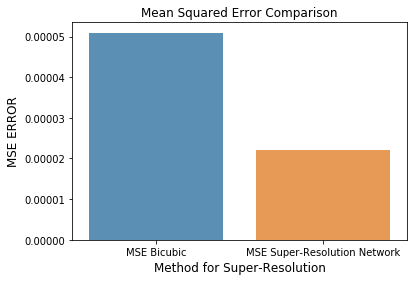

In [22]:
import pandas as pd 
# intialise data of lists with loss values. 
data = {'Method':['MSE Bicubic', 'MSE Super-Resolution Network'], 'MSE_loss':[bicubic_loss, model_loss.item()]}
  
# Create DataFrame 
df = pd.DataFrame(data) 

plt.figure()
sns.barplot(df['Method'], df['MSE_loss'], alpha=0.8)
plt.title('Mean Squared Error Comparison')
plt.ylabel('MSE ERROR', fontsize=12)
plt.xlabel('Method for Super-Resolution', fontsize=12)
plt.show()


We see from the above plot that the MSE of our 'model' is less than the 'bicubic interpolation' MSE, and as we know that MSE is the value of average of difference between each pixel value between two images (the smaller, the better), therefore we can say that our 'model' performs better than the bicubic interpolation method-which is ouur baseline method, in estimating the target image as its MSE is lower than bicubic interpolation MSE, which means the difference between the pixels of super-resolution image predicted by the model and the and original high-resolution image is very less.

**Hence we can say that our model performs better, and beats the baseline method, which is the aim of this challenge.**

Below, we show some of the predicted images alongside with the original images.

In [23]:
# We define a scene images iterator
test_scene_images = get_scene_images()

# We set it to cycle, so that its never exhausted and never returns an error to StopIteration
test_scene_images = cycle(test_scene_images)

def get_next_test_batch():
    """
    This method gets the next batch of images from the dataset
     """
    lr_images = []
    hr_images = []  
    for i in range(16):
        # Get the images from the generator for the next scene
        lr_image_stack,qm_images,hr_image,sm_image = next(test_scene_images)
        lr_images.append(lr_image_stack)
        hr_images.append(hr_image)
    lr_images = np.asarray(lr_images)
    hr_images = np.asarray(hr_images)
    return (lr_images, hr_images)

# Get the next batch of 16 images
lr_test_images, hr_test_images = get_next_test_batch()

# Reshape the image batch to feed it as input to the neuural network
lr_test_images = lr_test_images.reshape(16, 1,128,128)
hr_test_images = hr_test_images.reshape(16,1,384,384)

# Convert the image batches into tensors
lr_test_images = torch.from_numpy(lr_test_images).float()
hr_test_images = torch.from_numpy(hr_test_images).float()

# Transfer the data to CUDA device
lr_test_images = lr_test_images.to(device)
hr_test_images = hr_test_images.to(device)

# Perform the forward pass of the model
test_output = super_model.forward(lr_test_images)


In [24]:
"""
Tranfer all data from GPU to CPU, then detach the variables from the graph so that we can perform operations on the data,
annd finally rehape the data as required.
"""
test_output = test_output.cpu()
test_output = test_output.detach().numpy()
test_output = test_output.reshape(16,384,384)
hr_test_images = hr_test_images.cpu()
hr_test_images = hr_test_images.detach().numpy()
hr_test_images = hr_test_images.reshape(16,384,384)

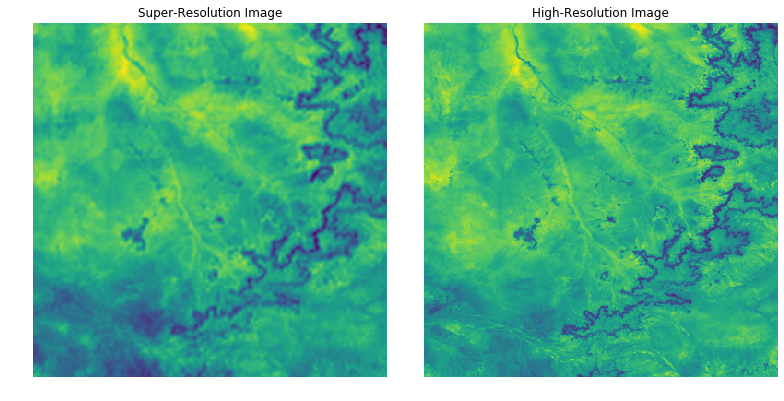

In [25]:
###############################################################################################################
# PLOT SOME OF THE EXAMPLES FROM THE DATASET, THE SUPER-RESOLVED IMAGE AND HIGH-RESOLUTION IMAGE SIDE BY SIDE.#
###############################################################################################################

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(11,11))
ax1 = fig.add_subplot(121)
ax1.imshow(test_output[4])
ax1.axis('off')
ax1.set_title('Super-Resolution Image')

ax2 = fig.add_subplot(122)
ax2.imshow(hr_test_images[4])
ax2.axis('off')
ax2.set_title('High-Resolution Image')
plt.tight_layout()



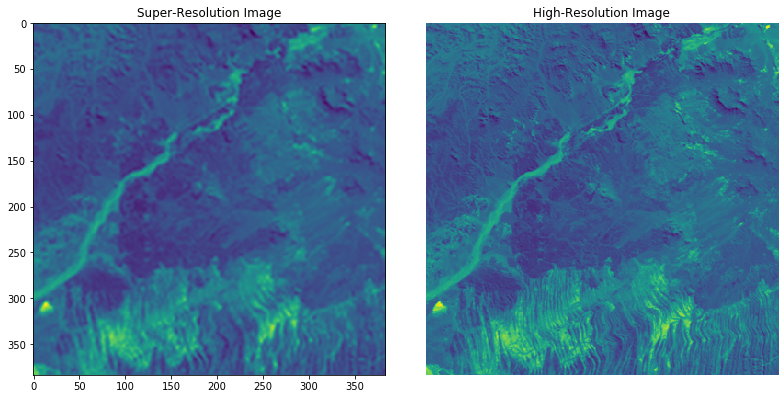

In [26]:
fig = plt.figure(figsize=(11,11))
ax1 = fig.add_subplot(121)
ax1.imshow(test_output[9])
ax1.set_title('Super-Resolution Image')

ax2 = fig.add_subplot(122)
ax2.imshow(hr_test_images[9])
ax2.axis('off')
ax2.set_title('High-Resolution Image')
plt.tight_layout()

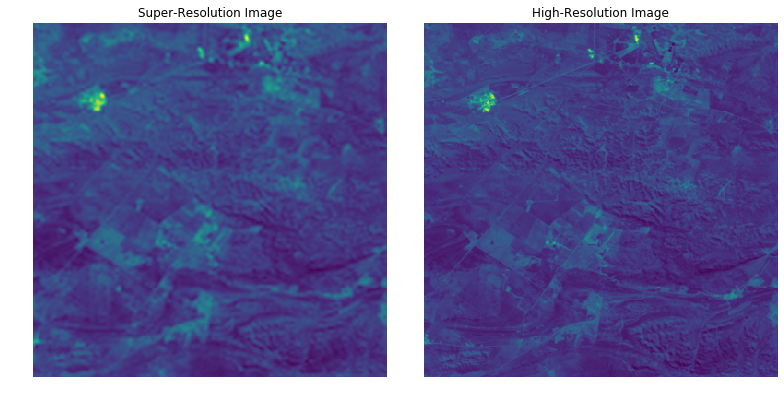

In [27]:
# HR image
fig = plt.figure(figsize=(11,11))
ax1 = fig.add_subplot(121)
ax1.imshow(test_output[1])
ax1.axis('off')
ax1.set_title('Super-Resolution Image')

#HR image mask
ax2 = fig.add_subplot(122)
ax2.imshow(hr_test_images[1])
ax2.axis('off')
ax2.set_title('High-Resolution Image')
plt.tight_layout()

<a id="Conclusion"></a>


<a id="Conclusion"></a>
# Conclusion
* The model we trained above gave us better results than the baseline bicubic interpolation method. Although, we combined multiple images by taking their median and forming a single image and then creating a super resolution image, it is not truly a **multi image super-resolution** algorithm, which the challenge demanded.  

* I tried to create a model for multi-image super-resolution as I have explained in my analysis above [[1]](MultiISR), but unfortunately due to time and system capability contraints, I was to not able to make it succesfully work, although I believe that that the method will work given some more in depth study and experimenting.  

* Also, I think GAN's are good for this kind of tasks and if we go in that direction and do some kind to gradual increase in the resolution of the low-resolution image to high-resolution image, we might be able to get even better results than state-of-the-art techniques, as GANs are very good at creating synthetic data, and that is the requirement of super-resolution as we need to fill in those pixel in super-resolution images which were not actually present.